In [167]:
import importlib.util
import numpy as np
from scipy.constants import c
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [168]:
um = 1e-6
nm = 1e-9
valor_lambda = 1550*nm
start_wavelenth = 1500*nm
stop_wavelenth = 1600*nm
number_point = 100000

file = 'ring_ressonator_Ideal'

In [169]:
ng = 4.3458796
neff = 2.35317
FSR = [1*nm, 10*nm, 20*nm]

Lr = np.zeros(len(FSR))

for i in range (len(FSR)):
    Lr[i] = valor_lambda**2/(ng*FSR[i])

    print(f'Para FSR = {FSR[i]/nm:.2f}nm:\nComprimento total do anel = {Lr[i]/um:.2f}\u03BCm\n')

Para FSR = 1.00nm:
Comprimento total do anel = 552.82μm

Para FSR = 10.00nm:
Comprimento total do anel = 55.28μm

Para FSR = 20.00nm:
Comprimento total do anel = 27.64μm



In [170]:
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

interApi = lumapi.INTERCONNECT(hide = False)

In [171]:
x_ona = 0
y_ona = 0

x_acoplador_direcional_sup = 25
y_acoplador_direcional_sup = 200

x_acoplador_direcional_inf = 25
y_acoplador_direcional_inf = 500

x_waveguide_esquerdo = -150
y_waveguide_esquerdo = 350

x_waveguide_direito = 200
y_waveguide_direito = 350



In [172]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 2)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)

In [173]:
interApi.switchtolayout()

interApi.select('Acoplador_Direcional_sup')
interApi.delete()
interApi.select('Acoplador_Direcional_inf')
interApi.delete()

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'Acoplador_Direcional_sup')
interApi.setposition('Acoplador_Direcional_sup', x_acoplador_direcional_sup, y_acoplador_direcional_sup)

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'Acoplador_Direcional_inf')
interApi.setposition('Acoplador_Direcional_inf', x_acoplador_direcional_inf, y_acoplador_direcional_inf)

In [174]:
interApi.switchtolayout()

interApi.select('WGD_esquerdo')
interApi.delete()
interApi.select('WGD_direito')
interApi.delete()

interApi.addelement('Straight Waveguide')
interApi.set('name', 'WGD_esquerdo')
interApi.setposition('WGD_esquerdo', x_waveguide_esquerdo, y_waveguide_esquerdo)
interApi.set('length', Lr[0]/2)
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)
interApi.setnamed('WGD_esquerdo', 'Rotated', 45)

interApi.addelement('Straight Waveguide')
interApi.set('name', 'WGD_direito')
interApi.setposition('WGD_direito', x_waveguide_direito, y_waveguide_direito)
interApi.set('length', Lr[0]/2)
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)
interApi.setnamed('WGD_direito', 'Rotated', 45)

In [175]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_sup', 'port 1')
interApi.connect('Acoplador_Direcional_sup', 'port 2', 'WGD_esquerdo', 'port 1')
interApi.connect('Acoplador_Direcional_sup', 'port 4', 'WGD_direito', 'port 1')
interApi.connect('WGD_esquerdo', 'port 2', 'Acoplador_Direcional_inf', 'port 1')
interApi.connect('WGD_direito', 'port 2', 'Acoplador_Direcional_inf', 'port 3')
interApi.connect('Acoplador_Direcional_sup', 'port 3', 'ONA', 'input 1')
interApi.connect('Acoplador_Direcional_inf', 'port 2', 'ONA', 'input 2')

1.0

In [176]:
interApi.save(file)

In [177]:
interApi.run(1)

In [178]:
def plot_valores(FSR):

    wavelength = np.array(FSR['wavelength']).flatten()
    transmission = np.array(FSR['TE gain (dB)'])

    return wavelength, transmission

In [179]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1, transmission_1 = plot_valores(FSR_1)
wavelength_2, transmission_2 = plot_valores(FSR_2)

In [180]:
def calcular_fsr_medio(wavelength, transmission, threshold=-17.25):
    minimos, _ = find_peaks(-transmission)
    vales = [idx for idx in minimos if transmission[idx] < threshold]
    if len(vales) < 2:
        return None

    vales_wavelengths = wavelength[vales]

    distancias_entre_vales = -np.diff(vales_wavelengths)

    fsr_medio = np.median(distancias_entre_vales)

    return fsr_medio

In [181]:
fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)

In [182]:
def y_min(value):
    return round(value / 3) * 3

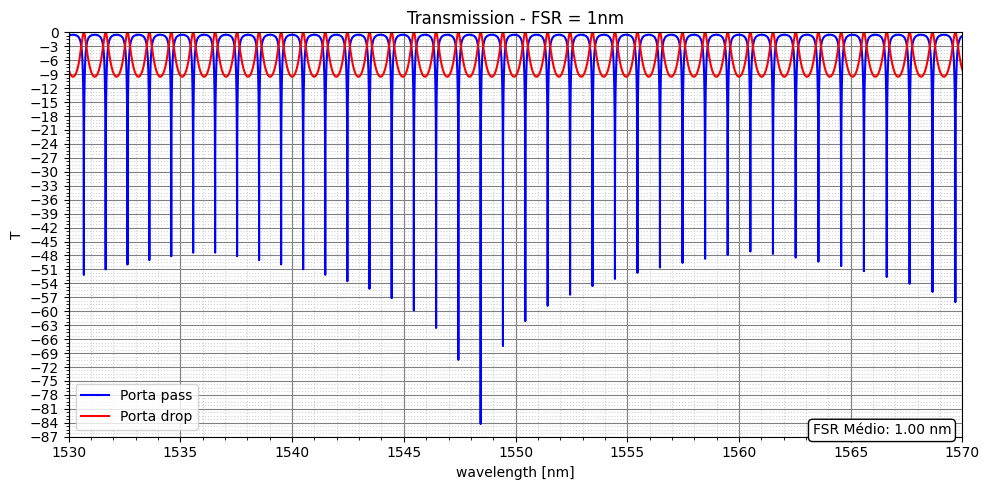

In [183]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm+30, stop_wavelenth/nm-30])
plt.ylim(y_min(transmission_1.min()), 0.01)
plt.title(r'Transmission - FSR = 1nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(y_min(transmission_1.min()), 0.01, 3))

plt.annotate(f'FSR Médio: {fsr_medio:.2f} nm',
             xy=(ax1.get_xlim()[1]-0.5, ax1.get_ylim()[0]+0.5),
             fontsize=10, color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
             ha='right')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 1nm.png')
plt.show()

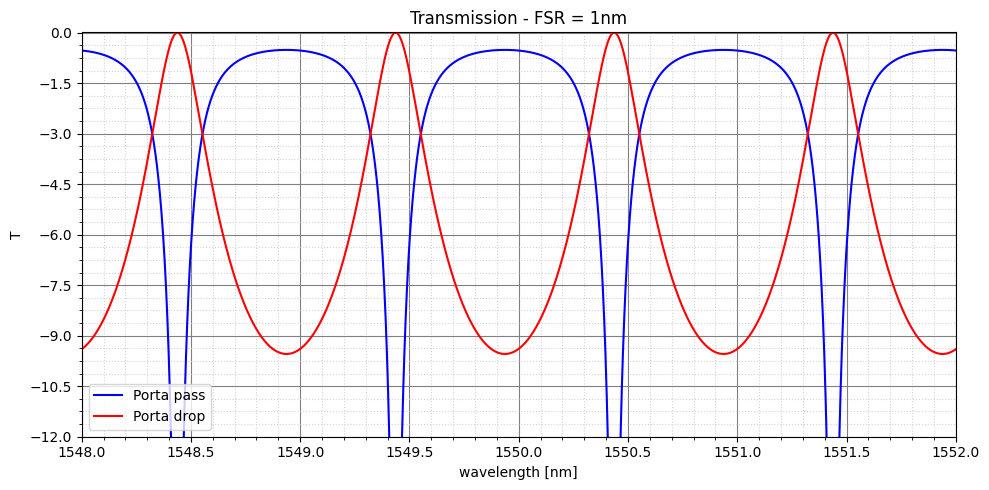

In [184]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([1548, 1552])
plt.ylim(-12, 0.01)
plt.title(r'Transmission - FSR = 1nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-12, 0.01, 1.5))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 1nm - zoom.png')
plt.show()

In [185]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_1 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_1 = np.array(FSR_1["TE free spectral range (m)"])

wavelength_2_1 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_1 = np.array(FSR_2["TE free spectral range (m)"]) 

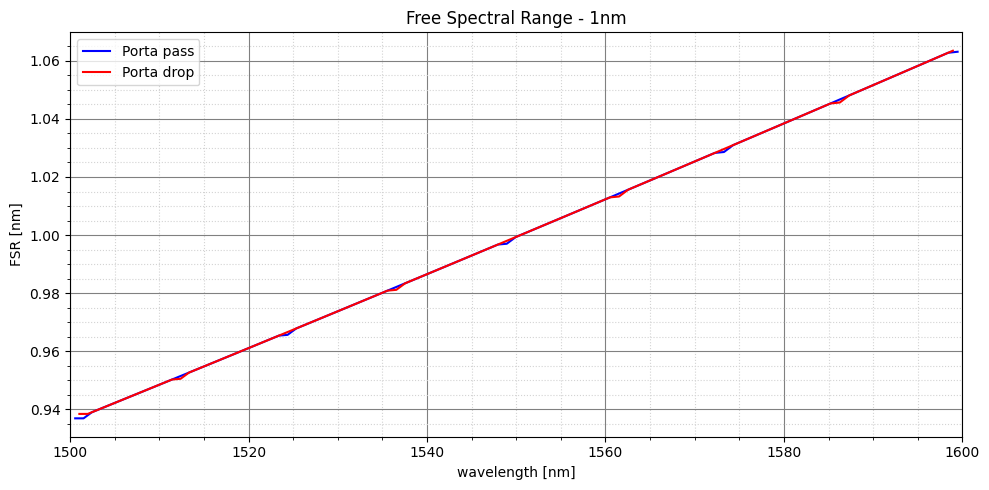

In [186]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

plt.plot(wavelength_1_1/nm, fsrplot_1_1/nm, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2_1/nm, fsrplot_2_1/nm, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, (stop_wavelenth)/nm])
plt.title(r'Free Spectral Range - 1nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 1nm.png')
plt.show()

In [187]:
interApi.switchtolayout()

interApi.select('WGD_esquerdo')
interApi.set('length', Lr[1]/2)
interApi.select('WGD_direito')
interApi.set('length', Lr[1]/2)

In [188]:
interApi.save(file)

In [189]:
interApi.run(1)

In [190]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1, transmission_1 = plot_valores(FSR_1)
wavelength_2, transmission_2 = plot_valores(FSR_2)

In [191]:
fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)

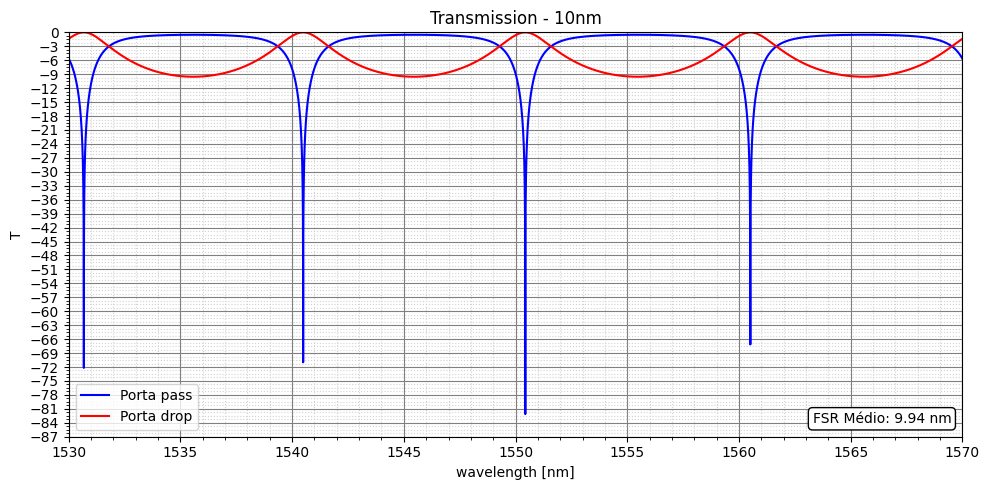

In [192]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm+30, stop_wavelenth/nm-30])
plt.ylim(y_min(transmission_1.min()), 0.01)
plt.title(r'Transmission - 10nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(y_min(transmission_1.min()), 0.01, 3))

plt.annotate(f'FSR Médio: {fsr_medio:.2f} nm',
             xy=(ax2.get_xlim()[1]-0.5, ax2.get_ylim()[0]+3),
             fontsize=10, color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
             ha='right')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 10nm.png')
plt.show()

In [193]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_10 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_10 = np.array(FSR_1["TE free spectral range (m)"])

wavelength_2_10 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_10 = np.array(FSR_2["TE free spectral range (m)"]) 

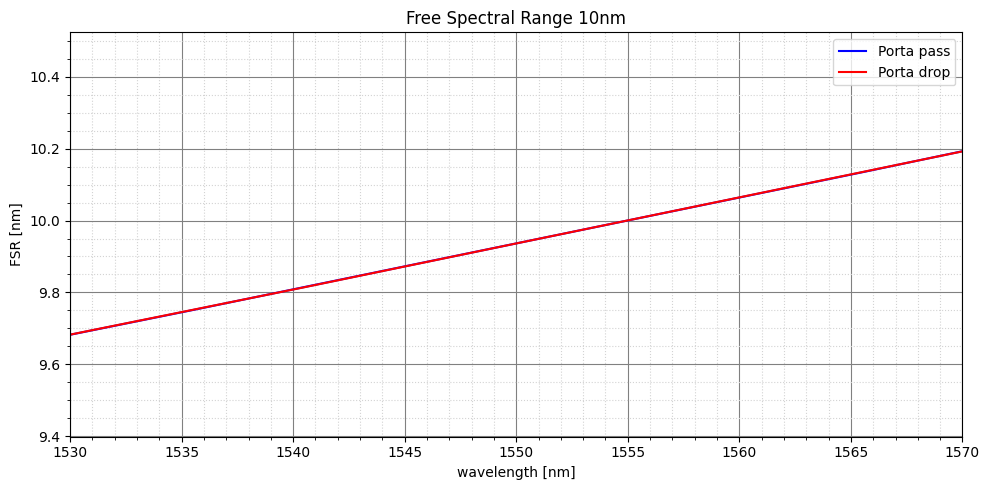

In [194]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111)

plt.plot(wavelength_1_10/nm, fsrplot_1_10/nm, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2_10/nm, fsrplot_2_10/nm, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm+30, stop_wavelenth/nm-30])
plt.title(r'Free Spectral Range 10nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 10nm.png')
plt.show()

In [195]:
interApi.switchtolayout()

interApi.select('WGD_esquerdo')
interApi.set('length', Lr[2]/2)
interApi.select('WGD_direito')
interApi.set('length', Lr[2]/2)

In [196]:
interApi.save(file)

In [197]:
interApi.run(1)

In [198]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1, transmission_1 = plot_valores(FSR_1)
wavelength_2, transmission_2 = plot_valores(FSR_2)

In [199]:
fsr_medio = calcular_fsr_medio(wavelength_1/nm, transmission_1)

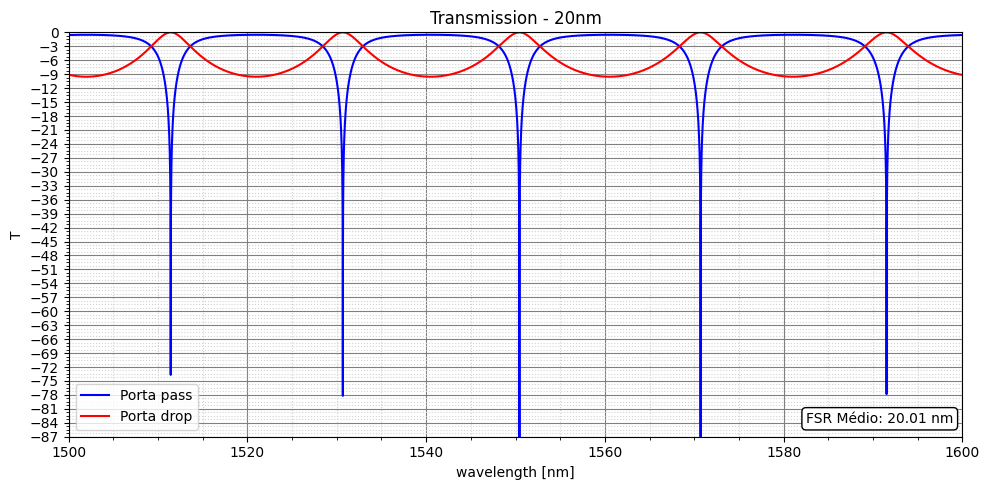

In [200]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=1.5, color='red')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.ylim(y_min(transmission_1.min()), 0.01)
plt.title(r'Transmission - 20nm')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(y_min(transmission_1.min()), 0.01, 3))

plt.annotate(f'FSR Médio: {fsr_medio:.2f} nm',
             xy=(ax3.get_xlim()[1]-1, ax3.get_ylim()[0]+3),
             fontsize=10, color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
             ha='right')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 20nm.png')
plt.show()

In [201]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_20 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_20 = np.array(FSR_1["TE free spectral range (m)"])

wavelength_2_20 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_20 = np.array(FSR_2["TE free spectral range (m)"])  

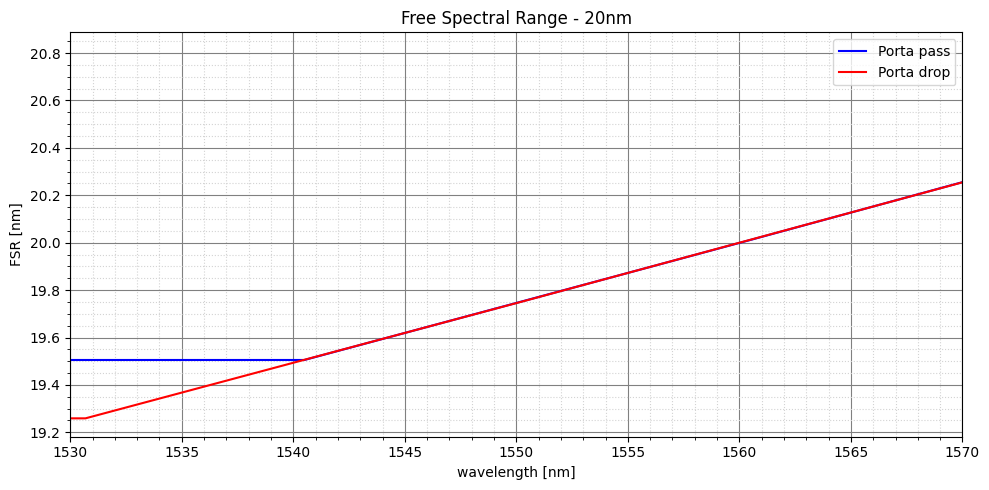

In [202]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)

plt.plot(wavelength_1_20/nm, fsrplot_1_20/nm, label = 'Porta pass', linewidth=1.5, color='blue')
plt.plot(wavelength_2_20/nm, fsrplot_2_20/nm, label = 'Porta drop', linewidth=1.5, color='red')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm+30, stop_wavelenth/nm-30])
plt.title(r'Free Spectral Range - 20nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 20nm.png')
plt.show()

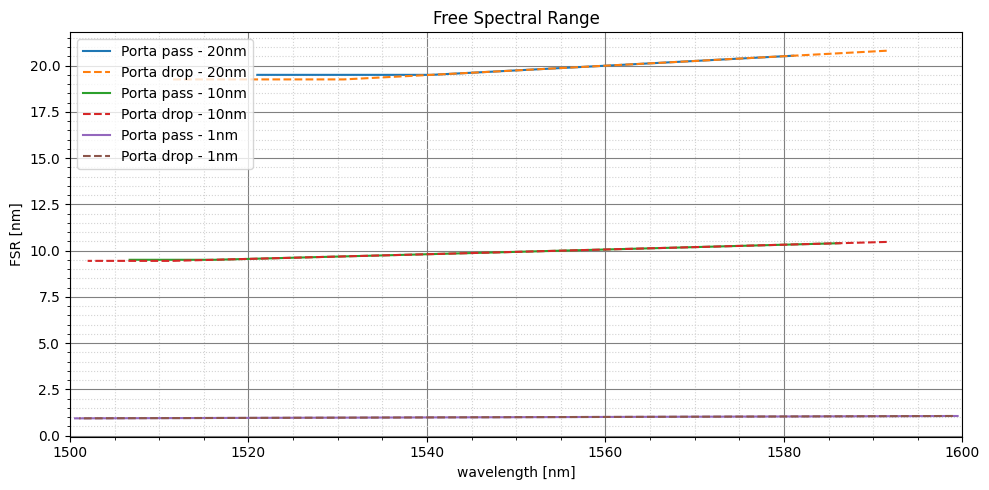

In [203]:
fig4 = plt.figure(figsize=(10,5))
ax4 = fig4.add_subplot(111)

plt.plot(wavelength_1_20/nm, fsrplot_1_20/nm, label = 'Porta pass - 20nm', linewidth=1.5)
plt.plot(wavelength_2_20/nm, fsrplot_2_20/nm, label = 'Porta drop - 20nm', linewidth=1.5, linestyle='--')
plt.plot(wavelength_1_10/nm, fsrplot_1_10/nm, label = 'Porta pass - 10nm', linewidth=1.5)
plt.plot(wavelength_2_10/nm, fsrplot_2_10/nm, label = 'Porta drop - 10nm', linewidth=1.5, linestyle='--')
plt.plot(wavelength_1_1/nm, fsrplot_1_1/nm, label = 'Porta pass - 1nm', linewidth=1.5)
plt.plot(wavelength_2_1/nm, fsrplot_2_1/nm, label = 'Porta drop - 1nm', linewidth=1.5, linestyle='--')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Free Spectral Range')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR.png')
plt.show()